# figures for ATOMIC paper

- timeseries of data & collocations with products
- spectrums 

In [1]:
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seawater as sw
import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features
import uuid
from scipy import interpolate
from scipy import signal
from glob import glob
from sklearn.linear_model import LinearRegression
from matplotlib import ticker, cm
import matplotlib.colors as colors
import datetime as dt
import scipy.ndimage
import spectrum

plt.rcParams['figure.figsize'] = (10.0, 8.0)

#create xarray dataset with saildrone filenames
#data directory for saildrone data
data_dir = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/ATOMIC/saildrone_usv_data/'
saildrone_filenames = [x for x in glob(data_dir+'saildrone*.nc')]

#data direcgtory for temperature logger .csv files
data_dir = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/ATOMIC/temp_log_proc/'
#adir_sbe='F:/data/cruise_data/saildrone/2020_atomic/temp_log_proc/'

#data direcgtory for temperature logger .csv files
figs_dir = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/ATOMIC/figs/'

#get list of all filenames in directory
logger_filenames = [x for x in glob(data_dir+'*1_min*.nc')]
#print('number of file:',len(files))
#print(files)

In [2]:
#subroutines for calculating PSD & making plot

def spectrum(data_in):
    #calculate PSD for each USV
    data_all=[]
    for iusv in range(3):
        ds_usv = data_in.isel(trajectory=iusv)
        ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)
        ds3 = ds2.swap_dims({'time':'dist_total'})
        dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],0.08)
        ds4 = ds3.interp(dist_total=dist_interp)
        den = ds4.density_mean.interpolate_na(dim='dist_total')
        den = den.where(np.isfinite(den),drop=True)
        ds4_detrend = signal.detrend(den)
        ds4_detrend_smooth = scipy.ndimage.filters.gaussian_filter1d(ds4_detrend, sigma=25)
        freq, Pxx_den = signal.periodogram(ds4_detrend_smooth,1/.080)  #fs = sampled at .08km or 80m
        freq2, Pxx_den2 = signal.welch(ds4_detrend_smooth,1/.080,nperseg=1024*30)  #fs = sampled at .08km or 80m
        if iusv==0:
            ps_all=Pxx_den[0:10000]
            ps_all_welch=Pxx_den2[0:10000]
        else:
            ps_all = np.vstack([ps_all,Pxx_den[0:10000]])
            ps_all_welch = np.vstack([ps_all_welch,Pxx_den2[0:10000]])    
    Pxx_den = np.mean(ps_all,axis=0)
    Pxx_den_welch = np.mean(ps_all_welch,axis=0)
    return freq,freq2,Pxx_den,Pxx_den_welch

def spectrum_time(data_in):
    #calculate PSD for each USV
    data_all=[]
    for iusv in range(3):
        ds_usv = data_in.isel(trajectory=iusv)
#        ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)
#        ds3 = ds2.swap_dims({'time':'dist_total'})
#        dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],0.08)
#        ds4 = ds3.interp(dist_total=dist_interp)
        den = ds_usv.density_mean.interpolate_na(dim='dist_total')
        den = den.where(np.isfinite(den),drop=True)
        ds4_detrend_smooth = signal.detrend(den)
        #ds4_detrend_smooth = scipy.ndimage.filters.gaussian_filter1d(ds4_detrend, sigma=25)
        freq, Pxx_den = signal.periodogram(ds4_detrend_smooth,1/1)  #fs = sampled at 1 min
        freq2, Pxx_den2 = signal.welch(ds4_detrend_smooth,1/1,nperseg=1024*30)  #fs = sampled at 1 min
        if iusv==0:
            ps_all=Pxx_den[0:10000]
            ps_all_welch=Pxx_den2[0:10000]
        else:
            ps_all = np.vstack([ps_all,Pxx_den[0:10000]])
            ps_all_welch = np.vstack([ps_all_welch,Pxx_den2[0:10000]])    
    Pxx_den = np.mean(ps_all,axis=0)
    Pxx_den_welch = np.mean(ps_all_welch,axis=0)
    return freq,freq2,Pxx_den,Pxx_den_welch


def cal_pdf(data_in): 
    #make arrays for sampling at different length scales
    length_scale = np.arange(.1,200,1)
    # create the empty data arrays to store the normalized histograms (normalized the *100 for percentage count)
    xx_in = np.arange(0,.2,.001)
    xx_in2 = np.arange(0,.2-.001,.001)
    data = np.zeros((len(length_scale),len(xx_in2)))
    ddn=xr.DataArray(data,dims=('length_scale','gradx'),coords={'length_scale':length_scale,'gradx':xx_in2})
    for iusv in range(3):
        ds_usv = data_in.isel(trajectory=iusv)
        ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)  #add dist traveled coordinate
        ds3 = ds2.swap_dims({'time':'dist_total'})                  #swap from time to distance traveled
        for ilen2,len2 in enumerate(length_scale):
            dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],len2)
            ds4 = ds3.interp(dist_total=dist_interp)       
            den_grad =  np.abs(np.gradient(ds4.density_mean)/len2)
            result,xx = np.histogram(den_grad,bins=xx_in)
            ddn[ilen2,:]=ddn[ilen2,:]+result
    for ilen2,len2 in enumerate(length_scale):
        ddn[ilen2,:]=ddn[ilen2,:]/sum(ddn[ilen2,:])*100  #normalize & turn into percent

    return ddn


def psd_fig(f,data_in,Pxx_den,text1,fout,ifit):
   
    length_scale = np.arange(.1,200,1)
    xx_in = np.arange(0,.2,.001)
    xx_in2 = np.arange(0,.2-.001,.001)
    print(len(length_scale),len(xx_in))
    fig = plt.figure(figsize=(14,10))
    tem=data_in
    tem = tem.where(tem>.003)
    Z=tem.T
    ax = plt.pcolormesh(length_scale,xx_in2,Z, norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),vmin=.01,vmax=100,cmap='hot')
    plt.text(25,0.178,'(a)'+text1,fontsize=16,color='k')
    plt.xlabel('Length scale (km)',fontsize=16)
    plt.ylabel('Density gradient (kg m$^{-3}$ km$^{-1}$)',fontsize=16)
    cb = plt.colorbar()
    cb.set_label(label='Percent count',fontsize=16)

    plt.axes([.43, .57, .3, .3])

    #cal PSD
    #Pxx_den = np.mean(psd_in,axis=0)
    #f, Pxx_den = signal.periodogram(Pxx_den,1/.080)  #fs = sampled at .08km or 80m
    istart,iend=10,5550
    plt.loglog(f[istart:iend], Pxx_den[istart:iend])

    #linear regression to PSD
    istart,iend=8,ifit
    XX = np.log(f[istart:iend])
    YY = np.log(Pxx_den[istart:iend])
    reg = LinearRegression().fit(XX.reshape(-1, 1), YY)
    a = float(reg.coef_)
    b = -1*float(reg.intercept_)
    plt.loglog(f[istart:iend], f[istart:iend]**(a)/np.exp(b),'r') #test from fit
    slp_str = 'slope = '+"{:.1f}".format(a)
    plt.text(.02,10,slp_str,fontsize=16,color='r')
    plt.ylim([10e-6,10e1])
    plt.xlim([10e-4,10e-1])
    plt.xticks(ticks=[.001,.01,.1,1],labels=['1000','100','10','1'])

    plt.text(.0011,2,'(b)',fontsize=16,color='k')
    #plt.xlabel('Wavenumber (cpkm)')
    plt.xlabel('Wavelength (km)')
    plt.ylabel('PSD ((kg m$^{-3}$)$^2$ cpkm$^{-1}$]')
    plt.grid()
    plt.savefig(figs_dir+fout)
    return


# Read in USV data for all 3 Saildrone
- caluclate density and wind speed
- caluclate distance between successive obs
- caluculate total cumulative distance
- switch from time to cumulative distance as index
- interpolate data onto grid


In [3]:
ds=[]
for iusv in range(3):
    fname=saildrone_filenames[iusv]
    ds_usv=xr.open_dataset(fname).isel(trajectory=0).swap_dims({'obs':'time'})
    ds_usv.close()

    #make diruanl plot
    xlon=ds_usv.longitude.data
    time_offset_to_lmt=(xlon/360.)*24.*60
    tem = ds_usv.time+time_offset_to_lmt*np.timedelta64(1,'m')# dt.timedelta(seconds=1)
    ds_usv['tlmt']=tem

# try calculating diurnal variability as minimimum for given day
#    ds_usv2= ds_usv.swap_dims({'time':'tlmt'})
#    dymin = ds_usv2.groupby("tlmt.dayofyear").min()
#    ds_usv3 = ds_usv2.groupby("tlmt.dayofyear") - dymin
    #cal diurnal by subtracting mean from 6am hour
    ds_usv2= ds_usv.swap_dims({'time':'tlmt'})
    ds_usv2a = ds_usv2.where(ds_usv2.tlmt.dt.hour==6)
    dymn = ds_usv2a.groupby("tlmt.dayofyear").mean()
    ds_usv3 = ds_usv2.groupby("tlmt.dayofyear") - dymn

#    tem,ttem,atem=[],ds_usv.TEMP_SBE37_MEAN[0],ds_usv.TEMP_AIR_MEAN[0]
#    ds_sea = ds_usv.TEMP_SBE37_MEAN.copy(deep=True)
#    ds_air = ds_usv.TEMP_SBE37_MEAN.copy(deep=True)
#    for i in range(len(ds_sea)):
#        xhr = int(ds_usv.tlmt.dt.minute[i])
#        xmin = int(ds_usv.tlmt.dt.minute[i])
#        if (xhr==5) & (xmin==0):
#            ttem,atem=ds_usv.TEMP_SBE37_MEAN[i],ds_usv.TEMP_AIR_MEAN[i]
#        ds_sea[i]=ds_usv.TEMP_SBE37_MEAN[i]-ttem
#        ds_air[i]=ds_usv.TEMP_AIR_MEAN[i]-atem
#    ds_usv['dw_sea']=ds_sea
#    ds_usv['dw_air']=ds_air
#    ds_usv = add_den_usv(ds_usv)
#    ds_usv = add_flux_usv(ds_usv,1.0)   
    
    ds_usv['TEMP_AIR_MEAN_DW'] = ds_usv3.swap_dims({'tlmt':'time'}).drop({'tlmt'}).TEMP_AIR_MEAN
    ds_usv['TEMP_SBE37_MEAN_DW'] = ds_usv3.swap_dims({'tlmt':'time'}).drop({'tlmt'}).TEMP_SBE37_MEAN
    ds_usv['wspd']=np.sqrt(ds_usv.UWND_MEAN**2+ds_usv.VWND_MEAN**2)   
    tem=sw.dens0(ds_usv.SAL_SBE37_MEAN,ds_usv.TEMP_SBE37_MEAN)
    ds_usv['density_mean']=xr.DataArray(tem,dims=('time'),coords={'time':ds_usv.time})
    tem=sw.alpha(ds_usv.SAL_SBE37_MEAN,ds_usv.TEMP_SBE37_MEAN,ds_usv.BARO_PRES_MEAN*0) #pressure =0 at surface
    ds_usv['alpha_ME']=xr.DataArray(tem,dims=('time'),coords={'time':ds_usv.time})
    tem=sw.beta(ds_usv.SAL_SBE37_MEAN,ds_usv.TEMP_SBE37_MEAN,ds_usv.BARO_PRES_MEAN*0) #pressure =0 at surface
    ds_usv['beta_MEAN']=xr.DataArray(tem,dims=('time'),coords={'time':ds_usv.time})
    ds_usv['latitude']=ds_usv.latitude.interpolate_na(dim='time')
    ds_usv['longitude']=ds_usv.longitude.interpolate_na(dim='time')
    xlat=ds_usv.latitude
    xlon=ds_usv.longitude
    dkm2 = abs(np.abs((((xlon[1:].data-xlon[0:-1].data)**2+(xlat[1:].data-xlat[0:-1].data)**2)**.5)*110.567*np.cos(np.pi*xlat[1:].data/180)))
    dkm2=np.append(dkm2,dkm2[66238]) #add on last point
    dkm3 = dkm2.cumsum()
    ds_usv['dist_total']=xr.DataArray(dkm3,dims=('time'),coords={'time':ds_usv.time})
    ds_usv['dist_between']=xr.DataArray(dkm2,dims=('time'),coords={'time':ds_usv.time})
    if iusv==0:
        ds = ds_usv
    else:
        ds = xr.concat([ds,ds_usv],dim='trajectory')
ds_saildrone = ds.copy(deep=True)

#read in temperature loggers
ds_log = xr.open_mfdataset(data_dir+'*1_minute-v1.nc',combine='nested',concat_dim='trajectory')
ds_log.close()


ds_saildrone.wspd.attrs={'units':'m/s'}

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.


# print out difference between two salinity sensors

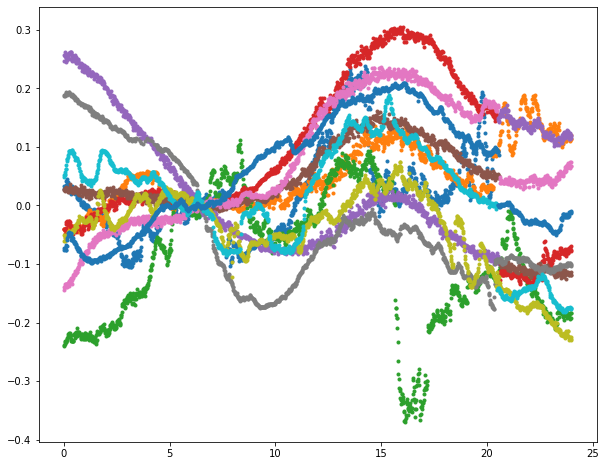

In [4]:
#i1,i2=2000,4000
#plt.plot(ds_usv.tlmt[i1:i2],ds_usv.TEMP_AIR_MEAN[i1:i2])
#tem=ds_usv3.sel(tlmt='2020-01-28')
#tem2=tem.where(tem.tlmt.dt.hour==6)
for i in range(45):
    tt=np.datetime64('2020-01-17')+np.timedelta64(24*(i-1),'h')
    tt2=tt+np.timedelta64(24,'h')
    tem = ds_usv.sel(time=slice(tt,tt2))
    if tem.wspd.mean().data<7.5:
        plt.plot(tem.tlmt.dt.hour+tem.tlmt.dt.minute/60,tem.TEMP_SBE37_MEAN_DW,'.')


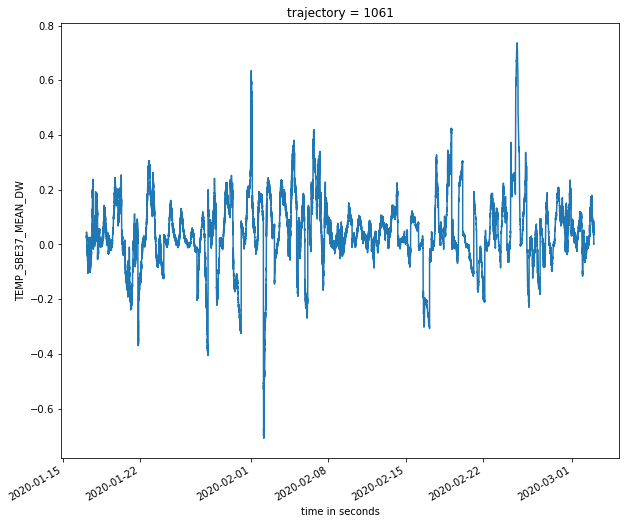

In [5]:
ds_usv.TEMP_SBE37_MEAN_DW.plot()

In [6]:
#dmin,dmax=np.log(min(sp[2:1000])),np.log(max(sp[2:1000]))
dmin,dmax=np.floor(100000*min(sp[2:1000]))/100000,np.ceil(max(sp[2:1000])/1000)*1000
print(dmin,dmax)

NameError: name 'sp' is not defined

In [ ]:
def spec(data,var):
    #calculate the periodogram spectrum spec_p
    #calculate the slepian multitaper spectrum spec_m
    ps_all,ps_all2=[],[]
    for iusv in range(3):
        ds_usv = data.isel(trajectory=iusv)
        den = ds_usv[var].interpolate_na(dim='time')
        den = den.where(np.isfinite(den),drop=True)
        ds4_detrend_smooth = signal.detrend(den)
        freq, Pxx_den = signal.periodogram(ds4_detrend_smooth,1/1)  #fs = sampled at 1 min
        ps_all.append(Pxx_den[0:10000])
        Sk_complex, weights, eigenvalues = spectrum.pmtm(ds4_detrend_smooth, NW=3.5, k=4, show=False)
        Sk = np.mean((abs(Sk_complex)**2) * weights.T, axis=0)
        ps_all2.append(Sk[0:10000])
    spec_p = np.mean(np.vstack(ps_all),axis=0)
    spec_m = np.mean(np.vstack(ps_all2),axis=0)
    return spec_p,spec_m,freq

ds_saildrone

list_var = ['TEMP_AIR_MEAN','TEMP_SBE37_MEAN','wspd','SAL_SBE37_MEAN']
for var in list_var:
    sp,sm,freq = spec(ds_saildrone,var)
    dmin,dmax=np.floor(1000000*min(sp[2:1000]))/10000,np.ceil(max(sp[2:1000])/1000)*1000
    plt.loglog([1/(60*6.15),1/(60*6.15)],[10e-5,10e3],'m')
    plt.loglog([1/(60*8),1/(60*8)],[10e-5,10e3],'r')
    plt.loglog([1/(60*12),1/(60*12)],[10e-5,10e3],'y')
    plt.loglog([1/(60*24),1/(60*24)],[10e-5,10e3],'g')
    plt.loglog(freq[0:1000], sp[0:1000],'b')
    plt.loglog(freq[0:1000], sm[0:1000],'k',lw=2)
    plt.ylim([dmin,dmax])
    ifit=500
    istart,iend=10,ifit
    XX = np.log(freq[istart:iend])
    YY = np.log(sp[istart:iend])
    reg = LinearRegression().fit(XX.reshape(-1, 1), YY)
    a = float(reg.coef_)
    b = -1*float(reg.intercept_)
    plt.loglog(freq[istart:iend], freq[istart:iend]**(a)/np.exp(b),'r') #test from fit
    slp_str = 'slope = '+"{:.1f}".format(a)
    plt.text(freq[istart+1],freq[istart]**(a)/np.exp(b)+500,slp_str,fontsize=16,color='r')  
    
    plt.xlabel('Frequency (min)')
    #plt.xlabel('Wavelength (km)')
    plt.ylabel('PSD (('+ds_usv[var].units+')$^2$ cpmin$^{-1}$]')
    plt.savefig('F:/data/cruise_data/saildrone/2020_atomic/fig/fig_spectrum_'+var+'.png')
    plt.clf()


In [ ]:
np.log(min(sp))

In [ ]:
#CALCULATE SPECTRUM sst TEMPERATURE, PEAKS AT 8, 12, 24 HRS
data_all=[]
for iusv in range(3):
    ds_usv = ds_saildrone.isel(trajectory=iusv)
    den = ds_usv.wspd.interpolate_na(dim='time')
    den = den.where(np.isfinite(den),drop=True)
    ds4_detrend_smooth = signal.detrend(den)
    freq, Pxx_den = signal.periodogram(ds4_detrend_smooth,1/1)  #fs = sampled at 1 min
    freq2, Pxx_den2 = signal.welch(ds4_detrend_smooth,1/1,nperseg=1024*30)  #fs = sampled at 1 min
    if iusv==0:
        ps_all=Pxx_den[0:10000]
        ps_all_welch=Pxx_den2[0:10000]
    else:
        ps_all = np.vstack([ps_all,Pxx_den[0:10000]])
        ps_all_welch = np.vstack([ps_all_welch,Pxx_den2[0:10000]])    
Pxx_den = np.mean(ps_all,axis=0)
Pxx_den_welch = np.mean(ps_all_welch,axis=0)
#plt.loglog([1/(60*8),1/(60*8)],[10e-5,10e3],'r')
plt.loglog([1/(60*12),1/(60*12)],[10e-5,10e4],'y')
plt.loglog([1/(60*24),1/(60*24)],[10e-5,10e4],'g')
plt.loglog(freq[0:1000], Pxx_den[0:1000],'b')
plt.ylim([10e-2,10e4])


#linear regression to PSD
ifit=500
istart,iend=10,ifit
XX = np.log(freq[istart:iend])
YY = np.log(Pxx_den[istart:iend])
reg = LinearRegression().fit(XX.reshape(-1, 1), YY)
a = float(reg.coef_)
b = -1*float(reg.intercept_)
plt.loglog(freq[istart:iend], freq[istart:iend]**(a)/np.exp(b),'r') #test from fit
slp_str = 'slope = '+"{:.1f}".format(a)
plt.text(freq[istart+1],freq[istart]**(a)/np.exp(b)+500,slp_str,fontsize=16,color='r')
#plt.ylim([10e-6,10e1])
#plt.xlim([10e-4,10e-1])
#plt.xticks(ticks=[.001,.01,.1,1],labels=['1000','100','10','1'])


In [ ]:
#CALCULATE SPECTRUM sst TEMPERATURE, PEAKS AT 6.2, 12, 24 HRS
data_all=[]
for iusv in range(3):
    ds_usv = ds_saildrone.isel(trajectory=iusv)
    den = ds_usv.SAL_SBE37_MEAN.interpolate_na(dim='time')
    den = den.where(np.isfinite(den),drop=True)
    ds4_detrend_smooth = signal.detrend(den)
    freq, Pxx_den = signal.periodogram(ds4_detrend_smooth,1/1)  #fs = sampled at 1 min
    freq2, Pxx_den2 = signal.welch(ds4_detrend_smooth,1/1,nperseg=1024*30)  #fs = sampled at 1 min
    if iusv==0:
        ps_all=Pxx_den[0:10000]
        ps_all_welch=Pxx_den2[0:10000]
    else:
        ps_all = np.vstack([ps_all,Pxx_den[0:10000]])
        ps_all_welch = np.vstack([ps_all_welch,Pxx_den2[0:10000]])    
Pxx_den = np.mean(ps_all,axis=0)
Pxx_den_welch = np.mean(ps_all_welch,axis=0)
#plt.loglog([1/(60*8),1/(60*8)],[10e-5,10e3],'r')
#plt.loglog([1/(60*12),1/(60*12)],[10e-5,10e3],'y')
#plt.loglog([1/(60*24),1/(60*24)],[10e-5,10e3],'g')
plt.loglog(freq[0:1000], Pxx_den[0:1000],'b')
plt.ylim([10e-5,10e3])


In [ ]:
# SBE37 minus RBR
dd=[]
for iusv in range(3):
    ds_usv=ds.isel(trajectory=iusv)
    dif = ds_usv.SAL_SBE37_MEAN-ds_usv.SAL_RBR_MEAN
    difm = dif.mean().data
    difs = dif.std().data
    print(ds_usv.trajectory.data,"{:.2f}".format(difm),"{:.2f}".format(difs),np.isfinite(dif).sum().data)
    if iusv==0:
        dd=ds_usv.SAL_SBE37_MEAN.data
    else:
        dd = np.concatenate([dd,ds_usv.SAL_SBE37_MEAN.data])
print("{:.2f}".format(np.nanmean(dd)),"{:.2f}".format(np.nanstd(dd)),np.isfinite(dd).sum())
    
# SBE37 minus RBR
dd=[]
for iusv in range(3):
    ds_usv=ds.isel(trajectory=iusv)
    dif = ds_usv.TEMP_SBE37_MEAN-ds_usv.TEMP_CTD_RBR_MEAN
    difm = dif.mean().data
    difs = dif.std().data
    print(ds_usv.trajectory.data,"{:.2f}".format(difm),"{:.2f}".format(difs),np.isfinite(dif).sum().data)
    if iusv==0:
        dd=ds_usv.SAL_SBE37_MEAN.data
    else:
        dd = np.concatenate([dd,ds_usv.SAL_SBE37_MEAN.data])
print("{:.2f}".format(np.nanmean(dd)),"{:.2f}".format(np.nanstd(dd)),np.isfinite(dd).sum())
    
# SBE37 minus RBR
dd=[]
for iusv in range(3):
    ds_usv=ds.isel(trajectory=iusv)
    dif = ds_usv.CHLOR_WETLABS_MEAN-ds_usv.CHLOR_RBR_MEAN
    difm = dif.mean().data
    difs = dif.std().data
    print(ds_usv.trajectory.data,"{:.2f}".format(difm),"{:.2f}".format(difs),np.isfinite(dif).sum().data)
    if iusv==0:
        dd=ds_usv.SAL_SBE37_MEAN.data
    else:
        dd = np.concatenate([dd,ds_usv.SAL_SBE37_MEAN.data])
print("{:.2f}".format(np.nanmean(dd)),"{:.2f}".format(np.nanstd(dd)),np.isfinite(dd).sum())

# SBE37 minus RBR
dd=[]
for iusv in range(3):
    ds_usv=ds.isel(trajectory=iusv)
    dif = ds_usv.O2_CONC_SBE37_MEAN-ds_usv.O2_CONC_RBR_MEAN 
    difm = dif.mean().data
    difs = dif.std().data
    print(ds_usv.trajectory.data,"{:.2f}".format(difm),"{:.2f}".format(difs),np.isfinite(dif).sum().data)
    if iusv==0:
        dd=ds_usv.SAL_SBE37_MEAN.data
    else:
        dd = np.concatenate([dd,ds_usv.SAL_SBE37_MEAN.data])
print("{:.2f}".format(np.nanmean(dd)),"{:.2f}".format(np.nanstd(dd)),np.isfinite(dd).sum())

    

In [ ]:
ds

In [ ]:
import math
var,fvar=['SAL_SBE37_MEAN','TEMP_SBE37_MEAN','density_mean'],'sst_sal'
#var,fvar=['TEMP_AIR_MEAN','TEMP_SBE37_MEAN','PAR_AIR_MEAN'],'air_wnd'
#var,fvar=['TEMP_AIR_MEAN_DW','TEMP_SBE37_MEAN_DW','PAR_AIR_MEAN'],'air_wnd_DW'
col=['tab:green','tab:red','tab:blue']
for iusv in range(3):
    fig,(ax0)= plt.subplots(1,1,figsize=(10,5))
    ds_usv = ds.isel(trajectory=iusv)
#    ax0.plot(ds_usv.time,ds_usv[var1],label=ds_usv.trajectory.data)
    t1,t2='2020-01-17T00','2020-03-02T23'
    
    ivar=0
    color,varin = col[ivar], var[ivar]
    ax0.set_xlabel('time (s)')
    ax0.set_ylabel(varin, color=color)
    ax0.plot(ds_usv.time, ds_usv[varin], color=color)
    ax0.tick_params(axis='y', labelcolor=color)
    ax0.set_xlim([np.datetime64(t1),np.datetime64(t2)])
    
    ax2 = ax0.twinx()  # instantiate a second axes that shares the same x-axis

    ivar=1
    color,varin = col[ivar], var[ivar]
    ax2.set_xlabel('time (s)')
    ax2.set_ylabel(varin, color=color)
    ax2.plot(ds_usv.time, ds_usv[varin], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    ax2 = ax0.twinx()  # instantiate a second axes that shares the same x-axis

    ivar=1
    color,varin = col[ivar], var[ivar]
    ax2.set_xlabel('time (s)')
    ax2.set_ylabel(varin, color=color)
    ax2.plot(ds_usv.time, ds_usv[varin], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    ax3 = ax0.twinx()  # instantiate a second axes that shares the same x-axis

    ivar=2
    color,varin = col[ivar], var[ivar]
    ax3.set_xlabel('time (s)')
    ax3.set_ylabel(varin, color=color)
    ax3.plot(ds_usv.time, ds_usv[varin], color=color)
    ax3.tick_params(axis='y', labelcolor=color)
    ax3.spines["right"].set_position(("axes", +1.1))

    ax2a = ax0.twiny()  # instantiate a second axes that shares the same x-axis

    # Decide the ticklabel position in the new x-axis,
    # then convert them to the position in the old x-axis
    #calculate new ticks
    temdist = ds_usv.dist_total.data
    print(ds_usv.dist_total[0].data,ds_usv.dist_total[-1].data)
    tem = np.arange(math.ceil(ds_usv.dist_total[0].data/500)*500,math.floor(ds_usv.dist_total[-1].data/500)*500+600,1000)
    ll=[]
    for i in tem: #range(3750,4450,100):
        ll.append("{:.0f}".format(i))
    isv=[]
    for i in tem:
        ii = np.argwhere((ds_usv.dist_total.data.astype(int))==i)
        if len(ii)>0:
            isv.append(int(ii.mean())/len(temdist))   
    
    new_tick_locations = isv
    print(new_tick_locations)
    ax2a.set_xticks(new_tick_locations)
    ax2a.set_xticklabels(ll)
    ax2a.set_xlabel('distance along track (km)')
    plt.savefig(figs_dir+ fvar + '_timeseries_'+str(iusv)+'.png')
#    plt.savefig(figs_dir+ '_timeseries_'+str(iusv)+'.png')



In [ ]:

import math
var,fvar=['SAL_SBE37_MEAN','TEMP_SBE37_MEAN','density_mean'],'sst_sal'
#var,fvar=['TEMP_AIR_MEAN','TEMP_SBE37_MEAN','PAR_AIR_MEAN'],'air_wnd'
#var,fvar=['TEMP_AIR_MEAN_DW','TEMP_SBE37_MEAN_DW','PAR_AIR_MEAN'],'air_wnd_DW0201'
col=['tab:green','tab:red','tab:blue']
for iusv in range(3):
    fig,(ax0)= plt.subplots(1,1,figsize=(10,5))
    ds_usv = ds.isel(trajectory=iusv)
#    ax0.plot(ds_usv.time,ds_usv[var1],label=ds_usv.trajectory.data)
    t1,t2='2020-02-16T00','2020-02-21T23'
    
    ivar=0
    color,varin = col[ivar], var[ivar]
    ax0.set_xlabel('time (s)')
    ax0.set_ylabel(varin, color=color)
    ax0.plot(ds_usv.time, ds_usv[varin], color=color)
    ax0.tick_params(axis='y', labelcolor=color)
    ax0.set_xlim([np.datetime64(t1),np.datetime64(t2)])
    
    ax2 = ax0.twinx()  # instantiate a second axes that shares the same x-axis

    ivar=1
    color,varin = col[ivar], var[ivar]
    ax2.set_xlabel('time (s)')
    ax2.set_ylabel(varin, color=color)
    ax2.plot(ds_usv.time, ds_usv[varin], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    ax2 = ax0.twinx()  # instantiate a second axes that shares the same x-axis

    ivar=1
    color,varin = col[ivar], var[ivar]
    ax2.set_xlabel('time (s)')
    ax2.set_ylabel(varin, color=color)
    ax2.plot(ds_usv.time, ds_usv[varin], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    ax3 = ax0.twinx()  # instantiate a second axes that shares the same x-axis

    ivar=2
    color,varin = col[ivar], var[ivar]
    ax3.set_xlabel('time (s)')
    ax3.set_ylabel(varin, color=color)
    ax3.plot(ds_usv.time, ds_usv[varin], color=color)
    ax3.tick_params(axis='y', labelcolor=color)
    ax3.spines["right"].set_position(("axes", +1.1))

    ax2a = ax0.twiny()  # instantiate a second axes that shares the same x-axis

    # Decide the ticklabel position in the new x-axis,
    # then convert them to the position in the old x-axis
    #calculate new ticks
    temdist = ds_usv.dist_total.data
    print(ds_usv.dist_total[0].data,ds_usv.dist_total[-1].data)
    tem = np.arange(math.ceil(ds_usv.dist_total[0].data/500)*500,math.floor(ds_usv.dist_total[-1].data/500)*500+600,1000)
    ll=[]
    for i in tem: #range(3750,4450,100):
        ll.append("{:.0f}".format(i))
    isv=[]
    for i in tem:
        ii = np.argwhere((ds_usv.dist_total.data.astype(int))==i)
        if len(ii)>0:
            isv.append(int(ii.mean())/len(temdist))   
    
    new_tick_locations = isv
    print(new_tick_locations)
    ax2a.set_xticks(new_tick_locations)
    ax2a.set_xticklabels(ll)
    ax2a.set_xlabel('distance along track (km)')
    plt.savefig(figs_dir+ fvar + '_timeseries_'+str(iusv)+'.png')
#    plt.savefig(figs_dir+ '_timeseries_'+str(iusv)+'.png')



In [ ]:
ds_usv=ds.isel(trajectory=0)
print(ds_usv.time[0].data,ds_usv.time[-1])

# read in satellite data

In [ ]:
t1,t2=dt.datetime(2020,1,17),dt.datetime(2020,3,7)
fnames=[]
for i in range(46):
    t=t1+dt.timedelta(days=i)
    tdir = t-dt.timedelta(days=4)
    sdoy = str(tdir.timetuple().tm_yday).zfill(3)
    smon = str(t.month).zfill(2)
    sdy  = str(t.day).zfill(2)
    fname = 'Z:/SalinityDensity/smap/L3/JPL/V4.3/8day_running/2020/' + sdoy + '/SMAP_L3_SSS_2020'+smon+sdy+'_8DAYS_V4.3.nc'
    fnames.append(fname)
tem = xr.open_mfdataset(fnames,combine='nested',concat_dim='time')
tem = tem.rename({'latitude':'lat','longitude':'lon'}).sel(lon=slice(-64,-46),lat=slice(16,4))
ds_jpl = tem.load()

In [ ]:
t1,t2=dt.datetime(2020,1,17),dt.datetime(2020,3,7)
fnames=[]
for i in range(46):
    t=t1+dt.timedelta(days=i)
    tdir = t-dt.timedelta(days=4)
    sdoy = str(tdir.timetuple().tm_yday).zfill(3)
    sdoy2 = str(t.timetuple().tm_yday).zfill(3)
            #\\White_home_pc\f\data\sat_data\smap\SSS\L3\RSS\V4\8day_running\SCI\2020
    fname = '//white_home_pc/f/data/sat_data/smap/SSS/L3/RSS/V4/8day_running/SCI/2020/' + sdoy + '/RSS_smap_SSS_L3_8day_running_2020_'+sdoy2+'_FNL_v04.0.nc'
#    fname = 'Z:/SalinityDensity/smap/L3/RSS/V4/8day_running/SCI/2020/' + sdoy + '/RSS_smap_SSS_L3_8day_running_2020_'+sdoy2+'_FNL_v04.0.nc'
    fnames.append(fname)
tem = xr.open_mfdataset(fnames,combine='nested',concat_dim='time')
tem.coords['lon'] = (tem.coords['lon'] + 180) % 360 - 180
tem = tem.sortby(tem.lon)
tem = tem.sel(lon=slice(-64,-46),lat=slice(4,16))
ds_rss = tem.load()

# Make map

In [ ]:
def map_fig(ds_sat,ds,var,text1,text2,fout,date_str):
    ds_sat = ds_sat.sel(time=date_str)
    fig = plt.figure(figsize=(8,6))
    ax = plt.axes(projection = ccrs.PlateCarree())  # create a set of axes with Mercator projection
    im=ax.pcolormesh(ds_sat.lon,ds_sat.lat,ds_sat[var],vmin=34,vmax=36.5,transform=ccrs.PlateCarree(),cmap='viridis')
    for i in range(3):
        ds2 = ds.isel(trajectory=i)
        ax.scatter(ds2.longitude,ds2.latitude,c=ds2.SAL_SBE37_MEAN,vmin=34,vmax=36.5,
                      s=.15,transform=ccrs.PlateCarree(),label=ds2.trajectory.data,cmap='viridis')
        ds2a = ds.isel(trajectory=i).sel(time=date_str)
        ax.plot(ds2a.longitude,ds2a.latitude,'.',transform=ccrs.PlateCarree(),color='w')

    ax.coastlines(resolution='10m')                
    ax.set_extent([-64,-46,4,16])
    bx1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0, color='grey', alpha=0.5, linestyle='--')
    bx1.xlabels_top = False; bx1.ylabels_left = True
    bx1.ylabels_right = False; bx1.xlines = False
    bx1.xlocator = mticker.FixedLocator([-60,-55,-50,-45])
    bx1.xformatter = LONGITUDE_FORMATTER; bx1.yformatter = LATITUDE_FORMATTER

    #ax.legend()
    ax.text(-63.5,7.5,'South America',fontsize=14)
    ax.text(-63.5,5,text1,fontsize=14)
    ax.text(-63.5,4.3,text2,fontsize=14)
    cax = fig.add_axes([0.5, 0.8, 0.37, 0.02])
    cbar = fig.colorbar(im,cax=cax, orientation='horizontal')
    cbar.set_label('Salinity (psu)')
    fig.savefig(figs_dir+fout)     

date_str = '2020-01-30T1200'
text2='7 Feb 2020 8-day Average'

text1='RSS SMAP Salinity v4'
map_fig(ds_rss,ds,'sss_smap',text1,text2,'map_sss_rss_smap.png',date_str)

text1='RSS SMAP Salinity v4 - 40 km'
map_fig(ds_rss,ds,'sss_smap_40km',text1,text2,'map_sss_rss_smap40km.png',date_str)

text1='JPL SMAP Salinity v4.3'
map_fig(ds_jpl,ds,'smap_sss',text1,text2,'map_sss_jpl_smap.png',date_str)

# print stats

In [ ]:
tem = ds.sel(time='2020-01-30')
plt.plot(ds.longitude[0,:],ds.latitude[0,:])
plt.plot(tem.longitude[0,:],tem.latitude[0,:],'r.')

In [ ]:
def print_stats(tstr,ds_sat2,var,ds_in,varsst,varden):
    import xarray
    import seawater as sw
    print('******'+tstr+'*******')
    for iusv in range(3):
        ds_usv = ds_in.isel(trajectory=iusv)
        tem = ds_sat2.interp(time=ds_usv.time,lat=ds_usv.latitude,lon=ds_usv.longitude)
        dif = tem[var]-ds_usv.SAL_SBE37_MEAN
        difm = dif.mean().data
        difs = dif.std().data
        print(iusv,"{:.2f}".format(difm),"{:.2f}".format(difs),np.isfinite(dif).sum().data)
        tem2=sw.dens0(tem[var],tem[varsst]-273.15) #ds.TEMP_SBE37_MEAN[iusv,:])
        tem[varden]=xr.DataArray(tem2.data,dims=('time'),coords={'time':ds_usv.time})
        tem['dist_total']=xr.DataArray(ds_usv.dist_total.data,dims=('time'),coords={'time':ds_usv.time})
        if iusv==0:
            ds_out = tem
        else:
            ds_out = xr.concat([ds_out,tem],dim='trajectory')
    return ds_out

ds_rss_usv = print_stats('RSS',ds_rss,'sss_smap',ds,'surtep','density_mean')
ds_rss_usv40 = print_stats('RSS40km',ds_rss,'sss_smap_40km',ds,'surtep','density_mean')
ds_jpl_usv = print_stats('JPL',ds_jpl,'smap_sss',ds,'anc_sst','density_mean')


# print eddy TS

In [ ]:
iusv=0
ds_usv = ds.isel(trajectory=iusv).sel(time=slice('2020-02-15T09','2020-02-21T0029'))
print(ds_usv.dist_total[0].data,ds_usv.dist_total[-1].data)
ll=[]
for i in range(3750,4450,100):
    ll.append("{:.0f}".format(i))
print(ll)
fig,(ax0)= plt.subplots(1,1,figsize=(15,6))
t1,t2='2020-02-15T09','2020-02-21T00'
for iusv in range(3):
    ds_usv = ds.isel(trajectory=iusv).sel(time=slice(t1,t2))
    ax0.plot(ds_usv.time,ds_usv.SAL_SBE37_MEAN,label=ds_usv.trajectory.data)
ds_usv = ds_jpl_usv.isel(trajectory=0).sel(time=slice(t1,t2))
ax0.plot(ds_usv.time,ds_usv.smap_sss,label='JPL')
ds_usv = ds_rss_usv.isel(trajectory=0).sel(time=slice(t1,t2))
ax0.plot(ds_usv.time,ds_usv.sss_smap,label='RSS')
ax0.plot(ds_usv.time,ds_usv.sss_smap_40km,label='RSS 40 km')
ax0.legend()
ax0.set_ylabel('Salinity (psu)')
ax0.set_xlabel('Date')
ax0.set_xlim([np.datetime64(t1),np.datetime64(t2)])

pos = ax0.get_position()
pos.y0 = pos.y0+.04       # for example 0.2, choose your value
ax0.set_position(pos)
#handles, labels = ax.get_legend_handles_labels()
#ax0.get_xticklabels(), ha="right", rotation=45)
ax2 = ax0.twiny()
# Add some extra space for the second axis at the bottom
#fig.subplots_adjust(bottom=0.2)
# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.06))
ax1Ticks = ax0.get_xticks()   
ax2Ticks = ax1Ticks
new_tick_locations = np.arange(0,1,0.166)
print(new_tick_locations)
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(ll)
ax2.set_xlabel('distance along track (km)')
#labels = [item.get_text() for item in ax0.get_xticklabels()]
#ax0.set_xticklabels(labels,rotation=45) 
plt.savefig(figs_dir+'timeseries_eddy.png')
    

In [ ]:

freq_usv,freq2_usv,Pxx_den_usv,Pxx_den_welch_usv = spectrum(ds)
freq_jpl,freq2_jpl,Pxx_den_jpl,Pxx_den_welch_jpl = spectrum(ds_jpl_usv)
freq_rss,freq2_rss,Pxx_den_rss,Pxx_den_welch_rss = spectrum(ds_rss_usv)
freq_rss4,freq2_rss4,Pxx_den_rss4,Pxx_den_welch_rss4 = spectrum(ds_rss_usv40)

ddn_usv = cal_pdf(ds)
ddn_jpl = cal_pdf(ds_jpl_usv)
ddn_rss = cal_pdf(ds_rss_usv)
ddn_rss4 = cal_pdf(ds_rss_usv40)



In [ ]:
psd_fig(freq_usv,ddn_usv,Pxx_den_usv,'Saildrone','PSD_den_grad_usv.png',300)
psd_fig(freq_jpl,ddn_jpl,Pxx_den_jpl,'JPL','PSD_den_grad_jpl.png',45)
psd_fig(freq_rss,ddn_rss,Pxx_den_rss,'RSS','PSD_den_grad_rss_.png',45)
psd_fig(freq_rss4,ddn_rss4,Pxx_den_rss4,'RSS 40km','PSD_den_grad_rss_40km.png',75)


In [ ]:
print(1/freq_usv[3],1/freq_usv[300])
#calculate max gradient
data_in = ds_saildrone
#make arrays for sampling at different length scales
length_scale = np.arange(.1,200,1)
for iusv in range(3):
    ds_usv = data_in.isel(trajectory=iusv)
    ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)  #add dist traveled coordinate
    ds3 = ds2.swap_dims({'time':'dist_total'})                  #swap from time to distance traveled
    for ilen2,len2 in enumerate(length_scale):
        if ilen2>3:
            continue
        dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],len2)
        ds4 = ds3.interp(dist_total=dist_interp)       
        den_grad =  np.abs(np.gradient(ds4.density_mean)/len2)
        print(len2,max(den_grad))


In [ ]:
#test spatial resolution
ds_saildrone['sss_jpl']=ds_jpl_usv.smap_sss
ds_saildrone['sss_rss']=ds_rss_usv.sss_smap
ds_saildrone['sss_rss4']=ds_rss_usv.sss_smap_40km
length_scale = np.arange(10,500,10)
for ilen2,len2 in enumerate(length_scale):
    iusv=0
    ds_usv = data_in.isel(trajectory=iusv)
    ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)  #add dist traveled coordinate
    ds3 = ds2.swap_dims({'time':'dist_total'})                  #swap from time to distance traveled
    ds4 = scipy.ndimage.filters.gaussian_filter1d(ds3.SAL_SBE37_MEAN.data, sigma=len2)
#    dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],len2)
#    ds4 = ds3.interp(dist_total=dist_interp)       
    rdif1 = ds4 - ds3.sss_jpl #.data
    rdif2 = ds4 - ds3.sss_rss
    rdif3 = ds4 - ds3.sss_rss4
    print(len2,rdif1.std().data,rdif2.std().data,rdif3.std().data)
    

In [ ]:
ds_usv = data_in.isel(trajectory=iusv)
ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)  #add dist traveled coordinate
ds3 = ds2.swap_dims({'time':'dist_total'})                  #swap from time to distance traveled
ds4 = scipy.ndimage.filters.gaussian_filter1d(ds3.SAL_SBE37_MEAN.data, sigma=200)
m1= ds3.sss_rss4-ds3.sss_rss4.mean()
print(np.mean(ds4))
m2 = ds4-np.nanmean(ds4)
m1 = m1[:50000]
m2 = m2[:50000]
plt.plot(m1)
plt.plot(m2)
print(np.std(m1-m2).data)
#plt.plot(ds3.sss_rss4)

In [ ]:
import datetime as dt
t1,t2=dt.datetime(2020,1,17),dt.datetime(2020,3,7)
fnames=[]
for i in range(46):
    t=t1+dt.timedelta(days=i)
    tdir = t-dt.timedelta(days=4)
    sdoy = str(tdir.timetuple().tm_yday).zfill(3)
    smon = str(t.month).zfill(2)
    sdy  = str(t.day).zfill(2)
    fname = 'Z:/SalinityDensity/smap/L3/JPL/V4.3/8day_running/2020/' + sdoy + '/SMAP_L3_SSS_2020'+smon+sdy+'_8DAYS_V4.3.nc'
    fnames.append(fname)
tem = xr.open_mfdataset(fnames,combine='nested',concat_dim='time')
tem = tem.rename({'latitude':'lat','longitude':'lon'}).sel(lon=slice(-64,-46),lat=slice(16,4))
ds_jpl = tem.load()

In [ ]:
#cal PSD
fig = plt.figure(figsize=(14,14))
#Pxx_den = np.mean(ps_all_usv,axis=0)
#f, Pxx_den = signal.periodogram(Pxx_den,1/.080)  #fs = sampled at .08km or 80m
istart,iend=5,5550
plt.loglog(freq_usv[istart:iend], Pxx_den_usv[istart:iend],'k',label='USV')
plt.loglog(freq_jpl[istart:iend], Pxx_den_jpl[istart:iend],'g',label='JPL')
plt.loglog(freq_rss[istart:iend], Pxx_den_rss[istart:iend],'r',label='RSS')
plt.loglog(freq_rss4[istart:iend], Pxx_den_rss4[istart:iend],'m',label='RSS 40km')

#linear regression to PSD
Pxx_den = np.mean(ps_all_usv,axis=0)
istart,iend=10,300
XX,YY = np.log(freq_usv[istart:iend]),np.log(Pxx_den[istart:iend])
reg = LinearRegression().fit(XX.reshape(-1, 1), YY)
a,b = float(reg.coef_), -1*float(reg.intercept_)
plt.loglog(f[istart:iend], f[istart:iend]**(a)/np.exp(b),'c',linewidth=2) #test from fit
slp_str = 'slope = '+"{:.1f}".format(a)
plt.text(.01,10,slp_str,fontsize=20,color='c')

plt.ylim([10e-5,10e1])
plt.xlim([.0015,.2])
plt.legend(fontsize=20)

#plt.text(.001,20,'(b)',fontsize=16,color='k')
plt.xlabel('Wavelength (km)',fontsize=20)
#plt.xlabel('Wavenumber (cpkm)',fontsize=20)
plt.ylabel('PSD ((kg m$^{-3}$)$^2$ cpkm$^{-1}$]',fontsize=20)
plt.xticks(ticks=[.01,.1],labels=['100','10'],fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.savefig(figs_dir+'all_spectrusm_only.png')


In [ ]:
import sys
sys.path.append('./../../flux/')
from coare3 import coare3
from gravity_constant import grv
jcool = 1 #ocean bulk temperature
WS_height = 4.5  #saildrone height obs
Ta_height = 2.3
Rs_mean = 312   #from eyeballing 1037 data
Rl_mean = 300  #from eyeballing 1037 data


jcool = 1 # implement cool calculation skin switch, 0=no, 1=yes

ds['sensible_heat_flux_v3']=ds.TEMP_AIR_MEAN.copy(deep=True)
ds['latent_heat_flux_v3']=ds.TEMP_AIR_MEAN.copy(deep=True)
ds['cool_skin_v3']=ds.TEMP_AIR_MEAN.copy(deep=True)
ds['skin_thickness_v3']=ds.TEMP_AIR_MEAN.copy(deep=True)
for i in range(3):
    ds2 = ds.isel(trajectory=i)
    
    inputs = {'u':ds2.wspd,
              't':ds2.TEMP_AIR_MEAN,
              'rh':ds2.RH_MEAN,
              'P':ds2.BARO_PRES_MEAN,
              'ts':ds2.TEMP_SBE37_MEAN,
              'lat':ds2.latitude,
             'zt':Ta_height,
             'zu':WS_height,
             'Rl':Rl_mean,
             'Rs':Rs_mean}
    res = coare3(inputs)
    ds2['sensible_heat_flux_v3']=xr.DataArray(res['hsb'][0,:].data,coords=[ds2.time],dims=['time'],
                                           attrs={'long_name':'sensible heat flux into ocean','units':'W/m^2'})
    ds2['latent_heat_flux_v3']=xr.DataArray(res['hlb'][0,:].data,coords=[ds2.time],dims=['time'],
                                           attrs={'long_name':'latent heat flux into ocean','units':'W/m^2'})
    ds2['cool_skin_v3']=xr.DataArray(res['dter'][0,:].data,coords=[ds2.time],dims=['time'],
                                           attrs={'long_name':'cool-skin temperature depression','units':'degC'})
    ds2['skin_thickness_v3']=xr.DataArray(res['tkt'][0,:].data,coords=[ds2.time],dims=['time'],
                                           attrs={'long_name':'cool-skin thickness','units':'m'})
    if i==0:
        ds3=ds2
    else:
        ds3=xr.concat([ds3,ds2],dim='trajectory')
ds['sensible_heat_flux_v3']=ds3.sensible_heat_flux_v3.copy(deep=True)
ds['latent_heat_flux_v3']=ds3.latent_heat_flux_v3.copy(deep=True)
ds['cool_skin_v3']=ds3.cool_skin_v3.copy(deep=True)
ds['skin_thickness_v3']=ds3.skin_thickness_v3.copy(deep=True)


In [ ]:
#hist air sea temp diff
for iusv in range(3):
    ds_usv = ds.isel(trajectory=iusv)
    dif = ds_usv.TEMP_AIR_MEAN-ds_usv.TEMP_SBE37_MEAN
    hist, bin_edges = np.histogram(dif,bins=np.arange(-3.5,4,0.01))
    if iusv==0:
        hist2 = hist
    else:
        hist2+=hist
    dif = ds_usv.TEMP_AIR_MEAN-(ds_usv.TEMP_SBE37_MEAN-ds_usv.cool_skin_v3)
    hist, bin_edges = np.histogram(dif,bins=np.arange(-3.5,4,0.01))
    if iusv==0:
        hist4 = hist
    else:
        hist4+=hist
hist2=hist2/sum(hist2)
hist4=hist4/sum(hist4)
plt.plot(bin_edges[:-1],hist2,label='Tair-Tdepth')
plt.plot(bin_edges[:-1],hist4,'r',label='Tair-Tskin')
print((ds_usv.TEMP_AIR_MEAN-ds_usv.TEMP_SBE37_MEAN).mean().data,(ds_usv.TEMP_AIR_MEAN-(ds_usv.TEMP_SBE37_MEAN-ds_usv.cool_skin_v3)).mean().data)
plt.legend()
plt.savefig(figs_dir+'hist_TairMinusTbulk.png')  

In [ ]:
ds_usv

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection = ccrs.PlateCarree())  # create a set of axes with Mercator projection
#im=ax.pcolormesh(ds_sat.lon,ds_sat.lat,ds_sat[var],vmin=34,vmax=36.5,transform=ccrs.PlateCarree(),cmap='viridis')
for i in range(3):
    ds2 = ds.isel(trajectory=i)
    ax.scatter(ds2.longitude,ds2.latitude,c=ds2.TEMP_AIR_MEAN-ds2.TEMP_SBE37_MEAN,vmin=-1,vmax=1,
                  s=.15,transform=ccrs.PlateCarree(),label=ds2.trajectory.data,cmap='seismic')

ax.coastlines(resolution='10m')                
ax.set_extent([-64,-46,4,16])
bx1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0, color='grey', alpha=0.5, linestyle='--')
bx1.xlabels_top = False; bx1.ylabels_left = True
bx1.ylabels_right = False; bx1.xlines = False
bx1.xlocator = mticker.FixedLocator([-60,-55,-50,-45])
bx1.xformatter = LONGITUDE_FORMATTER; bx1.yformatter = LATITUDE_FORMATTER

#ax.legend()
ax.text(-63.5,7.5,'South America',fontsize=14)
#ax.text(-63.5,5,text1,fontsize=14)
#ax.text(-63.5,4.3,text2,fontsize=14)
cax = fig.add_axes([0.5, 0.8, 0.37, 0.02])
cbar = fig.colorbar(im,cax=cax, orientation='horizontal')
cbar.set_label('Salinity (psu)')
#fig.savefig(figs_dir+fout)     


In [ ]:
ds

In [ ]:
ds2.cool_skin_v3.plot()
#ds2.skin_thickness_v3[0:10000].plot()

In [ ]:
for iusv in range(3):
    plt.scatter(ds_usv.SAL_SBE37_MEAN,ds_usv.TEMP_SBE37_MEAN,c=ds_usv.density_mean)


In [ ]:
def ts_plot(t1,t2,var1,var2,var3,var4,ystr,figs_dir,ds_in,ds_rss_in,ds_jpl_in,str2,offset):
    import math
    iusv=0
    ds_usv = ds_in.isel(trajectory=iusv).sel(time=slice(t1,t2))
    print(ds_usv.dist_total[0].data,ds_usv.dist_total[-1].data)
    ll=[]
    for i in range(3750,4450,100):
        ll.append("{:.0f}".format(i))
    print(ll)
    fig,(ax0)= plt.subplots(1,1,figsize=(15,6))
    for iusv in range(1):
        ds_usv = ds.isel(trajectory=iusv).sel(time=slice(t1,t2))
        ax0.plot(ds_usv.time,ds_usv[var1],label=ds_usv.trajectory.data)
    ds_usv = ds_jpl_in.isel(trajectory=0).sel(time=slice(t1,t2))
    ax0.plot(ds_usv.time,ds_usv[var2]+offset,label='JPL')
    ds_usv = ds_rss_in.isel(trajectory=0).sel(time=slice(t1,t2))
    ax0.plot(ds_usv.time,ds_usv[var3]+offset,label='RSS')
    ax0.plot(ds_usv.time,ds_usv[var4]+offset,label='RSS 40 km')
    ax0.legend()
    ax0.set_ylabel(ystr)
    ax0.set_xlabel('Date')
#    ax0.set_xlim([np.datetime64(t1),np.datetime64(t2)])
    ax0.set_xlim([t1,t2])

    pos = ax0.get_position()
    #pos.y0 = pos.y0+.04       # for example 0.2, choose your value
    ax0.set_position(pos)
    ax2 = ax0.twiny()
    # Move twinned axis ticks and label from top to bottom
    ax2.xaxis.set_ticks_position("top")
    ax2.xaxis.set_label_position("top")
    # Offset the twin axis below the host
    #ax2.spines["bottom"].set_position(("axes", -0.06))
    ax1Ticks = ax0.get_xticks()   
    ax2Ticks = ax1Ticks
    
    #calculate new ticks
    temdist = ds_usv.dist_total.data
    print(ds_usv.dist_total[0].data,ds_usv.dist_total[-1].data)
    tem = np.arange(math.ceil(ds_usv.dist_total[0].data/50)*50,math.floor(ds_usv.dist_total[-1].data/50)*50+60,100)
    ll=[]
    for i in tem: #range(3750,4450,100):
        ll.append("{:.0f}".format(i))
    isv=[]
    for i in tem:
        ii = np.argwhere((ds_usv.dist_total.data.astype(int))==i)
        if len(ii)>0:
            isv.append(int(ii.mean())/len(temdist))   
    
    new_tick_locations = isv
    print(new_tick_locations)
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(ll)
    ax2.set_xlabel('distance along track (km)')
    plt.savefig(figs_dir+ 'timeseries_'+str(t1)+'eddy'+str2+'.png')

t1,t2 = np.datetime64('2020-02-15T09'),np.datetime64('2020-02-21T00')
offset=0
var1,var2,var3,var4,ystr= 'SAL_SBE37_MEAN','smap_sss','sss_smap','sss_smap_40km','Salinity (psu)'
ts_plot(t1,t2,var1,var2,var3,var4,ystr,figs_dir,ds,ds_rss_usv,ds_jpl_usv,'salinity',offset)

In [ ]:
t1,t2 = np.datetime64('2020-02-15T09'),np.datetime64('2020-02-21T00')
var1,var2,var3,var4,ystr= 'SAL_SBE37_MEAN','smap_sss','sss_smap','sss_smap_40km','Salinity (psu)'
dy1 = ds.time[0]
offset=0
for i in range(12):
    t1 = np.datetime64('2020-01-20')+np.timedelta64((i-1)*5,'D')
    t2 = t1+np.timedelta64(5,'D')
    ts_plot(t1,t2,var1,var2,var3,var4,ystr,figs_dir,ds,ds_rss_usv,ds_jpl_usv,'salinity',offset)

In [ ]:
t1,t2 = np.datetime64('2020-02-15T09'),np.datetime64('2020-02-21T00')
var1,var2,var3,var4,ystr= 'SAL_SBE37_MEAN','smap_sss','sss_smap','sss_smap_40km','Salinity (psu)'
dy1 = ds.time[0]
offset=0
for i in range(12):
    t1 = np.datetime64('2020-01-20')+np.timedelta64((i-1)*5,'D')
    t2 = t1+np.timedelta64(5,'D')
    ts_plot(t1,t2,var1,var2,var3,var4,ystr,figs_dir,ds,ds_rss_usv,ds_jpl_usv,'salinity',offset)

In [ ]:
t1,t2 = np.datetime64('2020-02-15T09'),np.datetime64('2020-02-21T00')
var1,var2,var3,var4,ystr= 'TEMP_SBE37_MEAN','anc_sst','surtep','surtep','SST (K)'
dy1 = ds.time[0]
offset=-273.15
for i in range(12):
    t1 = np.datetime64('2020-01-20')+np.timedelta64((i-1)*5,'D')
    t2 = t1+np.timedelta64(5,'D')
    ts_plot(t1,t2,var1,var2,var3,var4,ystr,figs_dir,ds,ds_rss_usv,ds_jpl_usv,'sst',offset)

In [ ]:
for i in range(1):
    t1 = np.datetime64('2020-01-20')+np.timedelta64((i-1)*5,'D')
    t2 = t1+np.timedelta64(5,'D')
    tem = ds_log.isel(trajectory=0)
    tem = tem.swap_dims({'obs':'time'}).sel(time=slice(t1,t2))
    plt.plot(tem.time,tem.sea_water_temperature_00_mean-tem.sea_water_temperature_03_mean)
    plt.plot(tem.time,tem.sea_water_temperature_01_mean-tem.sea_water_temperature_03_mean)
    plt.plot(tem.time,tem.sea_water_temperature_02_mean-tem.sea_water_temperature_03_mean)
        

In [ ]:
    tem = ds_log.isel(trajectory=0)
    tem2 = ds.isel(trajectory=0).sel(time=slice('2020-03-01','2020-03-10'))
    tem = tem.swap_dims({'obs':'time'})
#    plt.plot(tem.time,tem.sea_water_temperature_00_mean-tem.sea_water_temperature_03_mean)
#    plt.plot(ds.time,tem2.TEMP_SBE37_MEAN-tem.sea_water_temperature_03_mean)
#    plt.plot(ds.time,tem2.TEMP_SBE37_MEAN)
    plt.plot(tem2.time,tem2.wspd)
#    plt.plot(tem.time,tem.sea_water_temperature_01_mean-tem.sea_water_temperature_03_mean)
#    plt.plot(tem.time,tem.sea_water_temperature_02_mean-tem.sea_water_temperature_03_mean)


In [ ]:
tem2

# Check what the min/max/mean distance travelled between 1 min obs

In [ ]:
for iusv in range(3):
    print(ds.dist_between[iusv,:].min().data,ds.dist_between[iusv,:].max().data,ds.dist_between[iusv,:].mean().data)
#ave distance is 0.08 km = 80 m 

# Make an evenly sampled timeseries
- Swap the coordinates from time to distance_total
- interp along evenly sampled distance total, 80m (0.08km)

In [ ]:
ds_usv = ds.isel(trajectory=0)
ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)
ds3 = ds2.swap_dims({'time':'dist_total'})
dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],0.08)
ds4 = ds3.interp(dist_total=dist_interp)

In [ ]:
plt.plot(ds2.time,ds3.density_mean)
plt.plot(ds_usv.time,ds_usv.density_mean)


# detrend

In [ ]:
den = ds4.density_mean.interpolate_na(dim='dist_total')
ds4_detrend = signal.detrend(den)

In [ ]:
#plt.plot(ds4.density_mean)
#plt.plot(den)
plt.plot(ds4_detrend)

# , smooth using 2km gaussian filter then power density

In [ ]:
ds4_detrend_smooth = scipy.ndimage.filters.gaussian_filter1d(ds4_detrend, sigma=25)
plt.plot(ds4_detrend_smooth[5000:7000])
plt.plot(ds4_detrend[5000:7000])


In [ ]:
f, Pxx_den = signal.periodogram(ds4_detrend_smooth,1/.080)  #fs = sampled at .08km or 80m
plt.loglog(f[2:5000], Pxx_den[2:5000])
plt.loglog(f[2:5000], f[2:5000]**(-2.4)/100000)
#plt.semilogy(f[2:200], Pxx_den[2:200])
plt.xlabel('frequency [km]')
plt.ylabel('PSD [kg/m^3 /km]')

# okay, now do all the USV

In [ ]:
data_all=[]
for iusv in range(3):
    ds_usv = ds.isel(trajectory=0)
    ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)
    ds3 = ds2.swap_dims({'time':'dist_total'})
    dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],0.08)
    ds4 = ds3.interp(dist_total=dist_interp)
    den = ds4.density_mean.interpolate_na(dim='dist_total')
    ds4_detrend = signal.detrend(den)
    ds4_detrend_smooth = scipy.ndimage.filters.gaussian_filter1d(ds4_detrend, sigma=25)
    f, Pxx_den = signal.periodogram(ds4_detrend_smooth,1/.080)  #fs = sampled at .08km or 80m
    if iusv==0:
        data_all=ds4_detrend_smooth
        ps_all=Pxx_den[0:10000]
    else:
        data_all = np.concatenate([data_all,ds4_detrend_smooth])
        ps_all = np.vstack([ps_all,Pxx_den[0:10000]])
    print(iusv)
f, Pxx_den = signal.periodogram(data_all[:101000],1/.080)  #fs = sampled at .08km or 80m
plt.loglog(f[5:900], Pxx_den[5:900])
plt.loglog(f[5:900], f[5:900]**(-2.4)/100000)
plt.xlabel('frequency [km]')
plt.ylabel('PSD [kg/m^3 /km]')

In [ ]:
Pxx_den = np.mean(ps_all,axis=0)
#f, Pxx_den = signal.periodogram(data_all[:101000],1/.080)  #fs = sampled at .08km or 80m
plt.loglog(f[5:900], Pxx_den[5:900])
plt.loglog(f[5:900], f[5:900]**(-2.4)/100000)
plt.xlabel('frequency [km]')
plt.ylabel('PSD [kg/m^3 /km]')

In [ ]:
for iusv in range(3):
    len2=0.1
    ds_usv = ds.isel(trajectory=iusv)
    ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)  #add dist traveled coordinate
    ds3 = ds2.swap_dims({'time':'dist_total'})                  #swap from time to distance traveled
    dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],len2)
    ds4 = ds3.interp(dist_total=dist_interp)       
    den_grad =  np.abs(np.gradient(ds4.density_mean)/len2)
    print(np.nanmax(den_grad))
    print('dist:',dist_interp.max())

In [ ]:
for iusv in range(3):
    len2=0.1
    ds_usv = ds.isel(trajectory=iusv)
    ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)  #add dist traveled coordinate
    ds3 = ds2.swap_dims({'time':'dist_total'})                  #swap from time to distance traveled
    dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],len2)
    ds4 = ds3.interp(dist_total=dist_interp)       
    den_grad =  np.abs(np.gradient(ds4.density_mean)/len2)
    print(np.nanmax(den_grad))
    print('dist:',dist_interp.max())
    plt.plot(den_grad)

In [ ]:
for iusv in range(3):
    len2=0.1
    ds_usv = ds.isel(trajectory=iusv)
    ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)  #add dist traveled coordinate
    ds3 = ds2.swap_dims({'time':'dist_total'})                  #swap from time to distance traveled
    dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],len2)
    ds4 = ds3.interp(dist_total=dist_interp)       
    den_grad =  np.abs(np.gradient(ds4.SAL_SBE37_MEAN)/len2)
    print(np.nanmax(den_grad))
    print('dist:',dist_interp.max())
    plt.plot(den_grad)    
    plt.plot(ds4.SAL_SBE37_MEAN)

In [ ]:
g1=abs(np.gradient(ds2.density_mean))/0.08
g2=abs(np.gradient(ds4.density_mean))/20
r1,x=np.histogram(g1,bins=np.arange(0,0.04,0.001))
r2,x=np.histogram(g2,bins=np.arange(0.,0.04,0.001))
plt.plot(x[:-1],r1/sum(r1),'r')
plt.plot(x[:-1],r2/sum(r2),'b')

In [ ]:
plt.plot(ds2.dist_total,ds2.density_mean,'r')
plt.plot(ds4.dist_total,ds4.density_mean,'b.')

In [ ]:
for iusv in range(3):
    len2=0.1
    ds_usv = ds.isel(trajectory=iusv)
    plt.plot(ds_usv.time,ds_usv.SAL_SBE37_MEAN,label=ds_usv.trajectory.data)
    plt.legend()
    plt.xticks(rotation=45) 
    

In [ ]:
fig = plt.figure(figsize=(8,12))
ax = plt.axes(projection = ccrs.PlateCarree())  # create a set of axes with Mercator projection
for i in range(3):
    ds2 = ds.isel(trajectory=i)
    im=ax.scatter(ds2.longitude,ds2.latitude,c=ds2.SAL_SBE37_MEAN,vmin=34,vmax=36,
                  s=.15,transform=ccrs.PlateCarree(),label=ds2.trajectory.data,cmap='jet')
    ax.coastlines(resolution='10m')                
    ax.set_extent([-64,-46,4,16])
    #ax.legend()
cax = fig.add_axes([0.5, 0.6, 0.3, 0.02])
cbar = fig.colorbar(im,cax=cax, orientation='horizontal')
cbar.set_label('Salinity (psu)')
fig.savefig(figs_dir+'map_sss_nasa.png')    

# make map

In [ ]:
#make arrays for sampling at different length scales

sat_str = 'rss_40km'
data_in = ds_rss
data_in['density_mean']=data_in.sss_smap.copy(deep=True)
for iusv in range(3):   
    tem=sw.dens0(data_in.sss_smap_40km[iusv,:],data_in.surtep[iusv,:]-273.15) #ds.TEMP_SBE37_MEAN[iusv,:])
    data_in['density_mean'][iusv,:]=tem
data_in['dist_total']=ds.dist_total

data_all=[]
for iusv in range(3):
    ds_usv = data_in.isel(trajectory=iusv)
    ds_usv['dist_total']=ds.isel(trajectory=iusv).dist_total
    ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)
    ds3 = ds2.swap_dims({'time':'dist_total'})
    dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],0.08)
    ds4 = ds3.interp(dist_total=dist_interp)
    den = ds4.density_mean.interpolate_na(dim='dist_total')
    den = den.where(np.isfinite(den),drop=True)
    ds4_detrend = signal.detrend(den)
    ds4_detrend_smooth = scipy.ndimage.filters.gaussian_filter1d(ds4_detrend, sigma=25)
    f, Pxx_den = signal.periodogram(ds4_detrend_smooth,1/.080)  #fs = sampled at .08km or 80m
    if iusv==0:
        data_all=ds4_detrend_smooth
        ps_all=Pxx_den[0:10000]
    else:
        data_all = np.concatenate([data_all,ds4_detrend_smooth])
        ps_all = np.vstack([ps_all,Pxx_den[0:10000]])
    print(iusv)
f, Pxx_den = signal.periodogram(data_all[:101000],1/.080)  #fs = sampled at .08km or 80m


length_scale = np.arange(.1,100,1)
# create the empty data arrays to store the normalized histograms (normalized the *100 for percentage count)
xx_in = np.arange(0,.04,.001)
xx_in2 = np.arange(0,.04-.001,.001)
data = np.zeros((len(length_scale),len(xx_in2)))
ddn=xr.DataArray(data,dims=('length_scale','gradx'),coords={'length_scale':length_scale,'gradx':xx_in2})
for iusv in range(3):
    ds_usv = data_in.isel(trajectory=iusv)
    ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)  #add dist traveled coordinate
    ds3 = ds2.swap_dims({'time':'dist_total'})                  #swap from time to distance traveled
    for ilen2,len2 in enumerate(length_scale):
        dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],len2)
        ds4 = ds3.interp(dist_total=dist_interp)       
        den_grad =  np.abs(np.gradient(ds4.density_mean)/len2)
        result,xx = np.histogram(den_grad,bins=xx_in)
        ddn[ilen2,:]=ddn[ilen2,:]+result
for ilen2,len2 in enumerate(length_scale):
    ddn[ilen2,:]=ddn[ilen2,:]/sum(ddn[ilen2,:])*100  #normalize & turn into percent
    
print(len(length_scale),len(xx_in))
fig = plt.figure(figsize=(14,10))
tem=ddn
tem = tem.where(tem>.003)
Z=tem.T
ax = plt.pcolormesh(length_scale,xx_in2,Z, norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),vmin=.01,vmax=100,cmap='hot')
plt.text(25,0.036,'(a)'+sat_str,fontsize=16,color='k')
plt.xlabel('Length scale (km)',fontsize=16)
plt.ylabel('Density gradient (kg m$^{-3}$ km$^{-1}$)',fontsize=16)
cb = plt.colorbar()
cb.set_label(label='Percent count',fontsize=16)


plt.axes([.43, .57, .3, .3])


#cal PSD
Pxx_den = np.mean(ps_all,axis=0)
#f, Pxx_den = signal.periodogram(Pxx_den,1/.080)  #fs = sampled at .08km or 80m
istart,iend=10,5550
plt.loglog(f[istart:iend], Pxx_den[istart:iend])

#linear regression to PSD
istart,iend=10,1000
XX = np.log(f[istart:iend])
YY = np.log(Pxx_den[istart:iend])
reg = LinearRegression().fit(XX.reshape(-1, 1), YY)
a = float(reg.coef_)
b = -1*float(reg.intercept_)
plt.loglog(f[istart:iend], f[istart:iend]**(a)/np.exp(b),'r') #test from fit
slp_str = 'slope = '+"{:.1f}".format(a)
plt.text(.02,.1,slp_str,fontsize=16,color='r')
plt.ylim([10e-6,10e1])
plt.xlim([10e-4,10e-1])

plt.text(.002,20,'(b)',fontsize=16,color='k')
plt.xlabel('Wavenumber (cpkm)')
plt.ylabel('PSD ((kg m$^{-3}$)$^2$ cpkm$^{-1}$)')
plt.grid()
plt.savefig(figs_dir+'PSD_den_grad_sat_'+sat_str+'.png')

In [ ]:
istart,iend=10,32
print(1/f[istart],1/f[iend])

In [ ]:
istart,iend=10,115
print(1/f[istart],1/f[iend])

In [ ]:
ilen2=120
ds_usv = ds.isel(trajectory=0)
ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)
ds3 = ds2.swap_dims({'time':'dist_total'})
dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],ilen2)
ds4 = ds3.interp(dist_total=dist_interp)
ds5 = ds4.interp(dist_total=np.arange(ds2.dist_total[0],ds2.dist_total[-1],0.08))

In [ ]:
ds3.sel(dist_total=slice(3700,4200)).SAL_SBE37_MEAN.plot()
ds5.sel(dist_total=slice(3700,4200)).SAL_SBE37_MEAN.plot()

In [ ]:
data_in = ds
data_all=[]
for iusv in range(1):
    ds_usv = data_in.isel(trajectory=iusv)
    ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)
    ds3 = ds2.swap_dims({'time':'dist_total'})
    dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],0.08)
    ds4 = ds3.interp(dist_total=dist_interp)
    den = ds4.density_mean.interpolate_na(dim='dist_total')
    den = den.where(np.isfinite(den),drop=True)
    ds4_detrend = signal.detrend(den)
    ds4_detrend_smooth = scipy.ndimage.filters.gaussian_filter1d(ds4_detrend, sigma=25)
    freq, Pxx_den = signal.periodogram(ds4_detrend_smooth,1/.080)  #fs = sampled at .08km or 80m
    if iusv==0:
        data_all=ds4_detrend_smooth
        ps_all=Pxx_den[0:10000]
    else:
        data_all = np.concatenate([data_all,ds4_detrend_smooth])
        ps_all = np.vstack([ps_all,Pxx_den[0:10000]])
plt.loglog(freq[10:1000],Pxx_den[10:1000])

In [ ]:
data_in = ds
data_all=[]
for iusv in range(1):
    ds_usv = data_in.isel(trajectory=iusv)
    ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)
    ds3 = ds2.swap_dims({'time':'dist_total'})
    dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],0.08)
    ds4 = ds3.interp(dist_total=dist_interp)
    den = ds4.density_mean.interpolate_na(dim='dist_total')
    den = den.where(np.isfinite(den),drop=True)
    ds4_detrend = signal.detrend(den)
    ds4_detrend_smooth = scipy.ndimage.filters.gaussian_filter1d(ds4_detrend, sigma=25)
    #f, Pxx_den = signal.welch(x, fs, nperseg=1024)
    freq2, Pxx_den2 = signal.welch(ds4_detrend_smooth,1/.080,nperseg=1024*30)  #fs = sampled at .08km or 80m
#plt.loglog(freq2[10:1000],Pxx_den2[10:1000])
plt.loglog(freq[10:900],Pxx_den[10:900])
plt.loglog(freq2[5:200],Pxx_den2[5:200],'r')

#linear regression to PSD
istart,iend=5,200
XX = np.log(freq2[istart:iend])
YY = np.log(Pxx_den2[istart:iend])
reg = LinearRegression().fit(XX.reshape(-1, 1), YY)
a = float(reg.coef_)
b = -1*float(reg.intercept_)
plt.loglog(freq2[istart:iend], freq2[istart:iend]**(a)/np.exp(b),'k') #test from fit
print(a)

In [ ]:
print(1/freq2[200])
print(0.08*25)

In [ ]:
dir_adcp = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/ATOMIC/adcp/sd-1026/'
ds_adcp = xr.open_mfdataset(dir_adcp+'*.nc',combine='nested',concat_dim='obs')
ds_adcp.close()
ds_adcp=ds_adcp.isel(trajectory=0).swap_dims({'obs':'time'})
xlat=ds_adcp.latitude
xlon=ds_adcp.longitude
dkm2 = abs(np.abs((((xlon[1:].data-xlon[0:-1].data)**2+(xlat[1:].data-xlat[0:-1].data)**2)**.5)*110.567*np.cos(np.pi*xlat[1:].data/180)))
dkm2=np.append(dkm2,dkm2[9214]) #add on last point
dkm3 = dkm2.cumsum()
ds_adcp['dist_total']=xr.DataArray(dkm3,dims=('time'),coords={'time':ds_adcp.time})
ds_adcp['dist_between']=xr.DataArray(dkm2,dims=('time'),coords={'time':ds_adcp.time})


In [ ]:
ds_adcp

In [ ]:
def ts_plot(t1,t2,var1,var2,var3,var4,ystr,figs_dir,ds_in,ds_rss_in,ds_jpl_in,str2,offset):
    import math
    iusv=0
    ds_usv = ds_in.isel(trajectory=iusv).sel(time=slice(t1,t2))
    print(ds_usv.dist_total[0].data,ds_usv.dist_total[-1].data)
    ll=[]
    for i in range(3750,4450,100):
        ll.append("{:.0f}".format(i))
    print(ll)
    fig,(ax0)= plt.subplots(1,1,figsize=(15,6))
    for iusv in range(1):
        ds_usv = ds.isel(trajectory=iusv).sel(time=slice(t1,t2))
        ax0.plot(ds_usv.time,ds_usv[var1],label=ds_usv.trajectory.data)
    ds_usv = ds_jpl_in.isel(trajectory=0).sel(time=slice(t1,t2))
    ax0.plot(ds_usv.time,ds_usv[var2]+offset,label='JPL')
    ds_usv = ds_rss_in.isel(trajectory=0).sel(time=slice(t1,t2))
    ax0.plot(ds_usv.time,ds_usv[var3]+offset,label='RSS')
    ax0.plot(ds_usv.time,ds_usv[var4]+offset,label='RSS 40 km')
    ax0.legend()
    ax0.set_ylabel(ystr)
    ax0.set_xlabel('Date')
#    ax0.set_xlim([np.datetime64(t1),np.datetime64(t2)])
    ax0.set_xlim([t1,t2])

    pos = ax0.get_position()
#    pos.y0 = pos.y0+.04       # for example 0.2, choose your value
    ax0.set_position(pos)
    ax2 = ax0.twiny()
    # Move twinned axis ticks and label from top to bottom
    ax2.xaxis.set_ticks_position("top")
    ax2.xaxis.set_label_position("top")
    # Offset the twin axis below the host
#    ax2.spines["bottom"].set_position(("axes", -0.06))
    ax1Ticks = ax0.get_xticks()   
    ax2Ticks = ax1Ticks
    
    #calculate new ticks
    temdist = ds_usv.dist_total.data
    print(ds_usv.dist_total[0].data,ds_usv.dist_total[-1].data)
    tem = np.arange(math.ceil(ds_usv.dist_total[0].data/50)*50,math.floor(ds_usv.dist_total[-1].data/50)*50+60,100)
    ll=[]
    for i in tem: #range(3750,4450,100):
        ll.append("{:.0f}".format(i))
    isv=[]
    for i in tem:
        ii = np.argwhere((ds_usv.dist_total.data.astype(int))==i)
        if len(ii)>0:
            isv.append(int(ii.mean())/len(temdist))   
    
    new_tick_locations = isv
    print(new_tick_locations)
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(ll)
    ax2.set_xlabel('distance along track (km)')
    #plt.savefig(figs_dir+ 'timeseries_'+str(t1)+'eddy'+str2+'.png')

t1,t2 = np.datetime64('2020-02-15T09'),np.datetime64('2020-02-21T00')
offset=0
var1,var2,var3,var4,ystr= 'SAL_SBE37_MEAN','smap_sss','sss_smap','sss_smap_40km','Salinity (psu)'
ts_plot(t1,t2,var1,var2,var3,var4,ystr,figs_dir,ds_saildrone,ds_rss_usv,ds_jpl_usv,'salinity',offset)

In [ ]:
def ts_plot(t1,t2,var1,var2,var3,var4,ystr,figs_dir,ds_in,ds_rss_in,ds_jpl_in,str2,offset):
    import math
    iusv=0
    ds_usv = ds_in.isel(trajectory=iusv).sel(time=slice(t1,t2))
    print(ds_usv.dist_total[0].data,ds_usv.dist_total[-1].data)
    ll=[]
    for i in range(3750,4450,100):
        ll.append("{:.0f}".format(i))
    print(ll)
    fig,(ax0)= plt.subplots(1,1,figsize=(15,6))
    for iusv in range(1):
        ds_usv = ds.isel(trajectory=iusv).sel(time=slice(t1,t2))
        ax0.plot(ds_usv.time,ds_usv[var1],label=ds_usv.trajectory.data)
    ds_usv = ds_jpl_in.isel(trajectory=0).sel(time=slice(t1,t2))
    ax0.plot(ds_usv.time,ds_usv[var2]+offset,label='JPL')
    ds_usv = ds_rss_in.isel(trajectory=0).sel(time=slice(t1,t2))
    ax0.plot(ds_usv.time,ds_usv[var3]+offset,label='RSS')
    ax0.plot(ds_usv.time,ds_usv[var4]+offset,label='RSS 40 km')
    ax0.legend()
    ax0.set_ylabel(ystr)
    ax0.set_xlabel('Date')
#    ax0.set_xlim([np.datetime64(t1),np.datetime64(t2)])
    ax0.set_xlim([t1,t2])

    pos = ax0.get_position()
#    pos.y0 = pos.y0+.04       # for example 0.2, choose your value
    ax0.set_position(pos)
    ax2 = ax0.twiny()
    # Move twinned axis ticks and label from top to bottom
    ax2.xaxis.set_ticks_position("top")
    ax2.xaxis.set_label_position("top")
    # Offset the twin axis below the host
#    ax2.spines["bottom"].set_position(("axes", -0.06))
    ax1Ticks = ax0.get_xticks()   
    ax2Ticks = ax1Ticks
    
    #calculate new ticks
    temdist = ds_usv.dist_total.data
    print(ds_usv.dist_total[0].data,ds_usv.dist_total[-1].data)
    tem = np.arange(math.ceil(ds_usv.dist_total[0].data/50)*50,math.floor(ds_usv.dist_total[-1].data/50)*50+60,100)
    ll=[]
    for i in tem: #range(3750,4450,100):
        ll.append("{:.0f}".format(i))
    isv=[]
    for i in tem:
        ii = np.argwhere((ds_usv.dist_total.data.astype(int))==i)
        if len(ii)>0:
            isv.append(int(ii.mean())/len(temdist))   
    
    new_tick_locations = isv
    print(new_tick_locations)
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(ll)
    ax2.set_xlabel('distance along track (km)')

#    ds_tem = ds_adcp.sel(time=slice(t1,t2))
#    rx = ds_tem.dist_total#-ds_tem.dist_total[0]+ds_usv.dist_total[0]
#    rx = rx[::15]
#    ry=np.ones(len(rx))*31.5
#    dx,dy = ds_tem.vel_east[::15,0], ds_tem.vel_north[::15,0]
#    ax2.quiver(rx,ry,dx,dy,scale=10)

    #add scale arrow
#    ax2.quiver(ds_usv.dist_total[0],31.8,1,0,scale=10)
#    ax2.text(ds_usv.dist_total[0],32,'1 m/s')
#    ax2.set_ylim([30,38])


    
    #plt.savefig(figs_dir+ 'timeseries_'+str(t1)+'eddy'+str2+'.png')

t1,t2 = np.datetime64('2020-02-15T09'),np.datetime64('2020-02-21T00')
offset=0
var1,var2,var3,var4,ystr= 'SAL_SBE37_MEAN','smap_sss','sss_smap','sss_smap_40km','Salinity (psu)'
ts_plot(t1,t2,var1,var2,var3,var4,ystr,figs_dir,ds_saildrone,ds_rss_usv,ds_jpl_usv,'salinity',offset)




In [ ]:

t1,t2 = np.datetime64('2020-02-15T09'),np.datetime64('2020-02-21T00')
offset=0
var1,var2,var3,var4,ystr= 'SAL_SBE37_MEAN','smap_sss','sss_smap','sss_smap_40km','Salinity (psu)'
#ts_plot(t1,t2,var1,var2,var3,var4,ystr,figs_dir,ds_saildrone,ds_rss_usv,ds_jpl_usv,'salinity',offset)
#tem=ds_saildrone.sel(time=slice(t1,t2))

#tem = ds_adcp.sel(time=slice(t1,t2))
import math
iusv=0
 
ds_usv = ds_saildrone.isel(trajectory=iusv).sel(time=slice(t1,t2))
print(ds_usv.dist_total[0].data,ds_usv.dist_total[-1].data)
ll=[]
for i in range(3750,4450,100):
    ll.append("{:.0f}".format(i))
print(ll)
fig,(ax0)= plt.subplots(1,1,figsize=(15,9))
ds_usv = ds.isel(trajectory=iusv).sel(time=slice(t1,t2))
ax0.plot(ds_usv.dist_total,ds_usv[var1],'b',label=var1)

ds_tem = ds_adcp.sel(time=slice(t1,t2))
rx = ds_tem.dist_total-ds_tem.dist_total[0]+ds_usv.dist_total[0]
rx = rx[::15]
ry=np.ones(len(rx))*31.5
dx,dy = ds_tem.vel_east[::15,0], ds_tem.vel_north[::15,0]
ax0.quiver(rx,ry,dx,dy,scale=10)

rx = ds_usv.dist_total
rx = rx[::85]
ry=np.ones(len(rx))*37.5
dx,dy = ds_usv.UWND_MEAN[::85], ds_usv.VWND_MEAN[::85]
ax0.quiver(rx,ry,dx,dy,scale=170,color='g')

#add scale arrow
ax0.quiver(ds_usv.dist_total[0],31.8,1,0,scale=10)
ax0.text(ds_usv.dist_total[0],32,'1 m/s')
ax0.set_ylim([31,38])

ax0a=ax0.twinx()
ax0a.plot(ds_usv.dist_total,ds_usv.TEMP_SBE37_MEAN,'r',label='SST')
#ax0a.plot(ds_usv.dist_total,ds_usv.TEMP_AIR_MEAN,'r',label='Air')
ax0a.set_ylim([26.7,27.7])
ax0a.set_ylabel('SST (K)',color='r',fontsize=12)
ax0a.tick_params(axis='y', colors='red')
ax0.set_ylabel('SSS (psu)',color='b',fontsize=12)
ax0.tick_params(axis='y', colors='b')





In [ ]:
ds_usv.TEMP_AIR_MEAN.plot()

In [ ]:
tem.time[0:10].values

In [ ]:
#plt.arrow([0,1],[0, 0],[0.5,0.5],[0.5,0.5], head_width=0.05, head_length=0.1, fc='k', ec='k')
plt.quiver([0,1,2,3,4],[0,0,0,0,0],np.ones(5)*.5,np.ones(5)*.5)


In [ ]:
ds_usv.attrs['drone_id']

In [ ]:
for iusv in range(3):
    fname=saildrone_filenames[iusv]
    ds_usv=xr.open_dataset(fname).isel(trajectory=0).swap_dims({'obs':'time'})
    ds_usv.close()
    print(ds_usv.attrs['drone_id'],ds_usv.attrs['wmo_id'])

In [ ]:
iusv=0
data_in=ds_saildrone
data_in['rss']=ds_rss_usv.sss_smap
data_in['rss40']=ds_rss_usv.sss_smap_40km
data_in['jpl']=ds_jpl_usv.smap_sss
ds_usv = data_in.isel(trajectory=iusv)
ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)
ds3 = ds2.swap_dims({'time':'dist_total'})
dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],0.08)
ds4 = ds3.interp(dist_total=dist_interp)
den = ds4.SAL_SBE37_MEAN.interpolate_na(dim='dist_total')
denr = ds4.rss.interpolate_na(dim='dist_total')
denr4 = ds4.rss40.interpolate_na(dim='dist_total')
denj = ds4.jpl.interpolate_na(dim='dist_total')
#den = den.where(np.isfinite(den),drop=True)
ds4a = scipy.ndimage.filters.gaussian_filter1d(den, sigma=25*20)
den.plot()
denr.plot()
#denr4.plot()
denj.plot()
plt.plot(den.dist_total,ds4a)
plt.xlim([3500,5500])

In [ ]:
0.08*25